In [162]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [166]:
#Read the dataset
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.shape

(3540962, 10)

In [167]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [168]:
data.isnull().sum()

,0
Index,0
Arrival_Time,0
Creation_Time,0
x,0
y,0
z,0
User,0
Model,0
Device,0
gt,520357


In [169]:
data.dropna(inplace=True)

In [170]:
#Select relevant columns
har = data[['x','y','z','gt']]
har.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [171]:
har['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [173]:
stand = har[har['gt'] == 'stand']
stand.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [174]:
stand = stand.iloc[0:500,:]

In [175]:
sit = har[har['gt'] == 'sit'].iloc[0:500,:]
walk = har[har['gt'] == 'walk'].iloc[0:500,:]
stairsup = har[har['gt'] == 'stairsup'].iloc[0:500,:]
stairsdown = har[har['gt'] == 'stairsdown'].iloc[0:500,:]
bike = har[har['gt'] == 'bike'].iloc[0:500,:]
harnew = pd.concat([stand, sit, walk, stairsup, stairsdown, bike])

In [176]:
harnew.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [177]:
#Convert target to integers
harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
harnew['gt'].replace(to_replace = 'sit', value = 1, inplace = True)
harnew['gt'].replace(to_replace = 'walk', value = 2, inplace = True)
harnew['gt'].replace(to_replace = 'stairsup', value = 3, inplace = True)
harnew['gt'].replace(to_replace = 'stairsdown', value = 4, inplace = True)
harnew['gt'].replace(to_replace = 'bike', value = 5, inplace = True)
harnew.head()

<ipython-input-177-671255e9cf2d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
<ipython-input-177-671255e9cf2d>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,0
1,-0.832584,-9.713276,-0.606930,0
2,-1.018134,-9.935339,-0.544082,0
3,-1.222838,-10.142437,-0.566229,0
4,-1.577180,-10.480618,-0.402824,0


In [180]:
#Function to prepare the data
def data_preparing(df,  winSize):
    X, y = list(), list()
    for i in range(len(df) - winSize):
        features = df.iloc[:,:-1].values
        target = df.iloc[:,-1].values
        X_i = features[i:i+winSize]
        Y_i = target[i+winSize-1]
        X.append(X_i)
        y.append(Y_i)
    return np.array(X), np.array(y)

In [181]:
#Apply function and train-test split
n_features = 3 # this is number of channels
winSize = 100 # this is number of timesteps

X, y = data_preparing(harnew, winSize)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

(2900, 100, 3) (2900,)


In [182]:
#Transform to Tensor and Use Data Loader
# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 32
train_loader = DataLoader(train_data, batch_size = batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [183]:
#Observe batches for training
for X,y in train_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([32, 100, 3])
torch.Size([32])


In [184]:
#Observe batches for testing
for X,y in test_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([580, 100, 3])
torch.Size([580])


In [185]:
X,y = next(iter(test_loader))
print(X.shape)
print(y.shape)

torch.Size([580, 100, 3])
torch.Size([580])


In [186]:
#Create the LSTM model
class LSTM_model(nn.Module):
  def __init__(self,input_size, num_hidden, num_layers):
    super().__init__()

    # Define  parameters

    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # LSTM Layer

    self.lstm = nn.LSTM(input_size, num_hidden, num_layers, batch_first = True)

    # Output Layer

    self.out = nn.Linear(num_hidden,6)

  def forward(self,x):

    y, (h,c) = self.lstm(x)
    out = self.out(y)    # Output shape (batch, features, hidden)
    out = out[:,-1,:]    # Reshaped to (batch, hidden)

    return out, (h,c)

In [187]:
#Setting the parameters and creating instance of the LSTM
input_size  =  n_features
hidden_size = 200
num_layers  =  1
seqlength   = winSize      # T

lstmModel = LSTM_model(input_size, hidden_size, num_layers)

In [188]:
#Testing and Training

epochs = 101

# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(lstmModel.parameters(), momentum = 0.9, lr = 0.01)

lstmModel.to(device) # placing a model to device

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 lstmModel.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred, h = lstmModel(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 lstmModel.eval()

 with torch.no_grad():

    for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)


            ypred, h =  lstmModel(X)
            ypred = ypred.cpu()
            y = y.cpu()

 # Appending test accuracy

 testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
 if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')


 epochs : 0  loss :  0.43
 epochs : 10  loss :  0.32
 epochs : 20  loss :  0.12
 epochs : 30  loss :  0.08
 epochs : 40  loss :  0.01
 epochs : 50  loss :  0.01
 epochs : 60  loss :  0.00
 epochs : 70  loss :  0.00
 epochs : 80  loss :  0.00
 epochs : 90  loss :  0.01
 epochs : 100  loss :  0.00


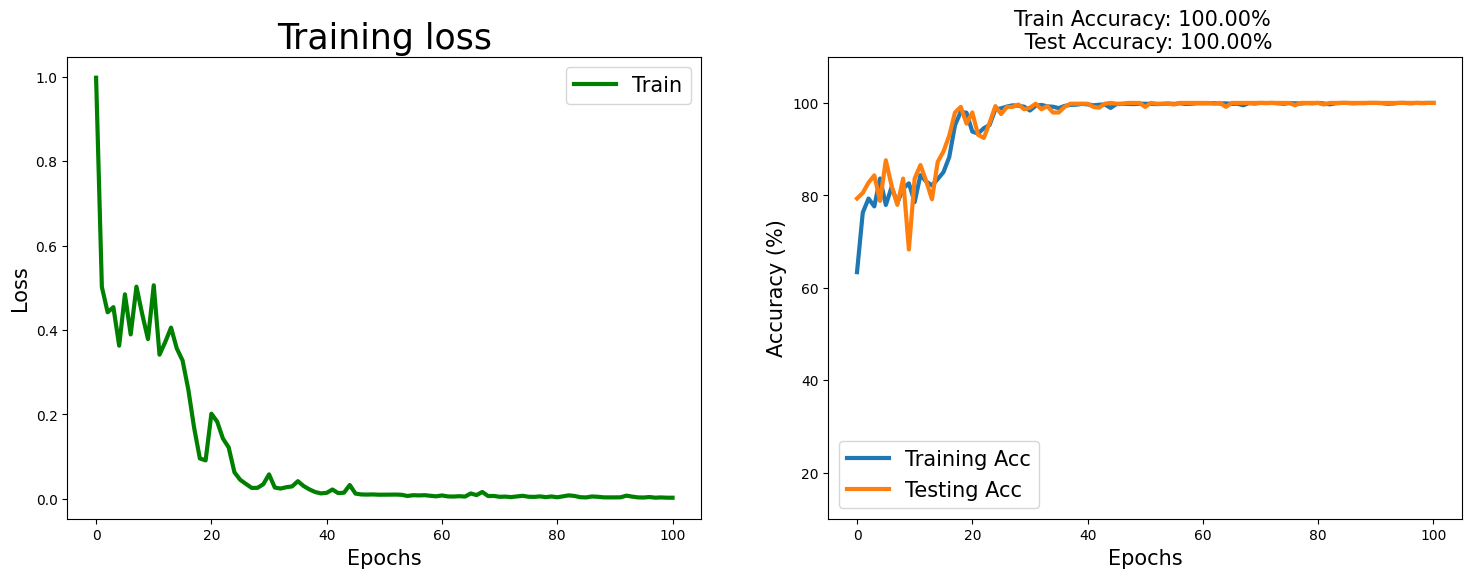

In [189]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()